In [1]:
import os

root_folder= 'D:/yogi/shoppin/ImageNet-Mini/augmented_images'
img_paths= []
labels= []

for dir, folder, files in os.walk(root_folder):

  for file in files:
    img_path= os.path.join(dir, file)
    img_paths.append(img_path)
    labels.append(os.path.basename(dir))

In [2]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
img_ids= label_encoder.fit_transform(labels)

In [3]:
from math import floor
import random

def split_data(img_paths, img_ids):

    # Combine data and labels into a list of tuples
    combined = list(zip(img_paths, img_ids))

    # Shuffle the combined list
    random.shuffle(combined)

    # Split the shuffled combined list into two lists
    split_index1 = floor(len(combined) * 0.8)
    split_index2 = floor(len(combined) * 0.9)

    train_combined  = combined[:split_index1]
    test_combined   = combined[split_index1:split_index2]
    enroll_combined = combined[split_index2:]

    # Unpack the combined tuples into separate paths and labels
    train_img_paths, train_img_ids   = zip(*train_combined)
    test_img_paths, test_img_ids     = zip(*test_combined)
    enroll_img_paths, enroll_img_ids = zip(*enroll_combined)

    return train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids


In [4]:
train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids= split_data(img_paths, img_ids)

### Dataloader

In [5]:
import os
import pandas as pd
from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels= labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
def transform_image():
  
  transform= transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [8]:
training_data   = CustomImageDataset(train_img_paths, train_img_ids, transform_image())
val_data        = CustomImageDataset(test_img_paths, test_img_ids, transform_image())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

### Build Autoencoder

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # -> [512, 14, 14]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Flatten(),  # Flatten to [512 * 14 * 14]
            nn.Linear(512 * 14 * 14, latent_dim)  # Latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 14 * 14),
            nn.Unflatten(1, (512, 14, 14)),  # Reshape to [512, 14, 14]
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [3, 224, 224]
            nn.Sigmoid()  # Output pixel values in [0, 1]
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return latent, reconstruction


In [11]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

model = Autoencoder(latent_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 10

for epoch in range(epochs):
    for images , _ in train_dataloader:
        images = images.to(device)
        
        # Forward pass
        latent, outputs = model(images)
        
        # Loss computation
        loss = criterion(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


KeyboardInterrupt: 

### Enrollment

In [33]:
import json

# Convert tensors to lists for serialization
def tensor_to_list(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensor to list
    raise TypeError(f"Object of type {obj.__class__.__name__} is not serializable")

def enroll_image(image_path, directory= './database_autoencoder', model=None, weights= True, transformation= transform_image()):

  image= Image.open(image_path).convert('RGB')
  transformed_image= transformation(image).unsqueeze(0).to(device)


  model.eval()  
  embeddings= model(transformed_image).reshape(1,-1)
  
  # name= image_path.split('.JPEG')[0] + '.json'
  name= os.path.basename(image_path).split('.JPEG')[0] + '.json'
  # print(name)

  output_path= os.path.join(directory, name)
  # print(output_path)
  value= {image_path: embeddings}
  # print(value)

  with open(output_path, 'w') as f:
      json.dump(value, f, default=tensor_to_list)

In [34]:
# Extract features
encoder = model.encoder

for i, path in enumerate(train_img_paths):
    enroll_image( path, model= encoder)

### Probe

In [35]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    # try:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

def top_k_matches(image_path=None, url= None, model= None, database_folder='./database_autoencoder', k=1, transformation= transform_image()):

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)


    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []

        # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((path, score))


    
    print(f'pehle scores: {scores}')

    # Sort the score list by the second value in reverse order
    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)

    print(f'scores: {sorted_scores}')

    # Define the grid size (rows and columns)
    rows = k
    cols = 2  # Adjust rows and cols based on `k`


    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))


    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array with one row

    # Loop through each row to plot input image and the corresponding match
    for i in range(rows):
        # Plot the input image in the first column
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input Image')

        # Plot the corresponding top match in the second column
        if i < k:
            retrieved_image = Image.open(sorted_scores[i][0])
            axes[i, 1].imshow(retrieved_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match {i + 1}")
        else:
            axes[i, 1].axis("off")  # Turn off any extra axes

    plt.tight_layout()
    plt.show()
    

    return sorted_scores

pehle scores: [('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_2.JPEG', array([[0.08276647]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_3.JPEG', array([[0.20477146]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_4.JPEG', array([[-0.00642867]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_1.JPEG', array([[0.35458136]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_2.JPEG', array([[0.32179034]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_4.JPEG', array([[0.30055305]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01910747\\ILSVRC2012_val_00000063_aug_1.JPEG', array([[0.3444729]], dtype=float32)), ('D:/yogi/shoppin/ImageNet

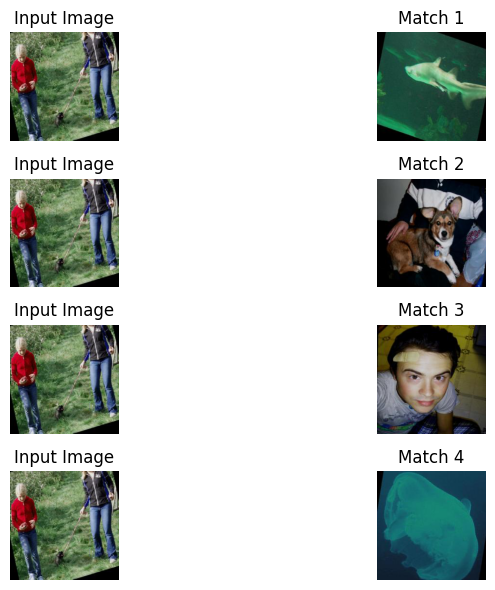

In [39]:
score= top_k_matches(image_path=enroll_img_paths[77], model= encoder, k=4)